In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("colorblind")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
mpl.rcParams["figure.dpi"] = 500
import cartopy.crs as ccrs
import cartopy as ct
import matplotlib.colors as c
import regionmask
import cmasher as cmr
import scipy
from cartopy.util import add_cyclic_point
mpl.rcParams['hatch.linewidth'] = 0.375
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from geocat.comp import eofunc_eofs, eofunc_pcs
from datetime import datetime
import warnings
from matplotlib.patches import Rectangle
import pdo_functions
import importlib
importlib.reload(pdo_functions)
import random
import numba
import statsmodels.api as sm
from sklearn.metrics import r2_score
import pandas as pd

In [2]:
# Open datasets
diff_ndsev = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ndsev/diff_trapp_ndsev_mam_1940-2024.nc')['__xarray_dataarray_variable__']
# hoog_ndsev = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ndsev/hoogewind_ndsev_mam_1940-2024.nc')['__xarray_dataarray_variable__']

cape = xr.open_mfdataset('/hurrell-scratch2/ivyglade/pdo/wrf_cape/era5_daily_max_mucape_*s.nc', combine='nested', concat_dim='year')['__xarray_dataarray_variable__']

s06 = xr.open_mfdataset('/hurrell-scratch2/ivyglade/pdo/ERA5_S06/era5_s06_*s.nc', combine='nested', concat_dim='time')['__xarray_dataarray_variable__']

In [3]:
# Select MAM only
cape_mam = cape.sel(date=cape.date.where(
                                   cape.date.str.startswith('03-') |
                                   cape.date.str.startswith('04-') |
                                   cape.date.str.startswith('05-'), 
                                   drop=True)).load()

s06_mam = s06.sel(time=s06.time.dt.month.isin([3, 4, 5])).load()

In [4]:
s06_mam = s06_mam.sel(latitude=slice(49, 24)).sel(longitude=slice(235, 294))

In [5]:
# Flatten to have a single time dimension - CAPE
cape_mam_stack = cape_mam.stack(time=('year', 'date'))

# Convert time to datetime
year = cape_mam_stack['time'].get_index('time').get_level_values('year')
date = cape_mam_stack['time'].get_index('time').get_level_values('date')

datetime = pd.to_datetime(year.astype(str) + '-' + date.astype(str))

cape_mam_stack = cape_mam_stack.assign_coords(time=datetime).transpose('time', 'latitude', 'longitude')

/tmp/ipykernel_23605/1307716612.py:10: FutureWarning: updating coordinate 'time' with a PandasMultiIndex would leave the multi-index level coordinates ['year', 'date'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['time', 'year', 'date'])` before assigning new coordinate values.
  cape_mam_stack = cape_mam_stack.assign_coords(time=datetime).transpose('time', 'latitude', 'longitude')


In [6]:
# Group by MAM and take the seasonal mean
cape_mam_mean = cape_mam_stack.resample(time='YE').mean()

s06_mam_mean = s06_mam.resample(time='YE').mean()

In [8]:
# Compute seasonal sums
diff_ndsev_mam = np.zeros((85, 101, 237))
# hoog_ndsev_mam = np.zeros((85, 101, 237))
for i in range(85):
    # Load in a year of data
    diff_load = diff_ndsev.isel(time=slice(i*92, (i+1)*92)).values
    # hoog_load = hoog_ndsev.isel(time=slice(i*92, (i+1)*92)).values

    # Sum up NDSEV days
    diff_ndsev_mam[i] = diff_load.sum(axis=0)
    # hoog_ndsev_mam[i] = hoog_load.sum(axis=0)

    # Progress
    print(f'{1940+i} is complete.')

1940 is complete.
1941 is complete.
1942 is complete.
1943 is complete.
1944 is complete.
1945 is complete.
1946 is complete.
1947 is complete.
1948 is complete.
1949 is complete.
1950 is complete.
1951 is complete.
1952 is complete.
1953 is complete.
1954 is complete.
1955 is complete.
1956 is complete.
1957 is complete.
1958 is complete.
1959 is complete.
1960 is complete.
1961 is complete.
1962 is complete.
1963 is complete.
1964 is complete.
1965 is complete.
1966 is complete.
1967 is complete.
1968 is complete.
1969 is complete.
1970 is complete.
1971 is complete.
1972 is complete.
1973 is complete.
1974 is complete.
1975 is complete.
1976 is complete.
1977 is complete.
1978 is complete.
1979 is complete.
1980 is complete.
1981 is complete.
1982 is complete.
1983 is complete.
1984 is complete.
1985 is complete.
1986 is complete.
1987 is complete.
1988 is complete.
1989 is complete.
1990 is complete.
1991 is complete.
1992 is complete.
1993 is complete.
1994 is complete.
1995 is co

In [9]:
# Open SST data and compute the PDO and Nino3.4
sst = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/HadISST_sst.nc')['sst']

pdo = pdo_functions.pdo_from_hadisst(sst, 1980, 2010)

nino_34 = pdo_functions.calc_nino_34_timeseries(sst, False, 1980, 2010)

In [18]:
# Standardize nino_34
nino_34_std = (nino_34 - nino_34.mean()) / nino_34.std()

In [10]:
# 3- month rolling mean
nino_34_rolling = nino_34.rolling(time=3, center=True).mean()

nino_34_calc = np.zeros((1860))
for i in range(1860):
    if i < 5:
        continue
    else:
        if (nino_34_rolling[(i-4)] > 0.5) & (nino_34_rolling[(i-3)] > 0.5) & (nino_34_rolling[(i-2)] > 0.5) & (nino_34_rolling[(i-1)] > 0.5) & (nino_34_rolling[i] > 0.5):
            nino_34_calc[i] = 1
        elif (nino_34_rolling[(i-4)] < -0.5) & (nino_34_rolling[(i-3)] < -0.5) & (nino_34_rolling[(i-2)] < -0.5) & (nino_34_rolling[(i-1)] < -0.5) & (nino_34_rolling[i] < -0.5):
            nino_34_calc[i] = -1
        else:
            continue

# convert nino_34_calc to xr
nino_34_calc_xr = xr.DataArray(nino_34_calc, coords={'time':sst['time']}, dims=['time'])

# 1940-2024 only
nino_34_1940_2024 = nino_34_calc_xr.sel(time=nino_34_calc_xr.time.dt.year.isin(np.arange(1940, 2025, 1)))
nino_34_1940_2024_mam = nino_34_1940_2024.sel(time=nino_34_1940_2024.time.dt.month.isin([3, 4, 5]))

In [19]:
# Convert pdo to xarray
pdo_xr = xr.DataArray(pdo, coords={'time':nino_34['time']}, dims=['time'])

# Subset only 1940-2024
pdo_1940_2024 = pdo_xr.sel(time=pdo_xr.time.dt.year.isin(np.arange(1940, 2025, 1)))
nino_34_1940_2024 = nino_34_std.sel(time=nino_34_std.time.dt.year.isin(np.arange(1940, 2025, 1)))

# only MAM and take seasonal averages
pdo_1940_2024_mam_szn = pdo_1940_2024.sel(time=pdo_1940_2024.time.dt.month.isin([3, 4, 5])).resample(time='YE').mean()
nino_34_1940_2024_mam_szn = nino_34_1940_2024.sel(time=nino_34_1940_2024.time.dt.month.isin([3, 4, 5])).resample(time='YE').mean()

pdo_1940_2024_mam_mon = pdo_1940_2024.sel(time=pdo_1940_2024.time.dt.month.isin([3, 4, 5]))
nino_34_1940_2024_mam_mon = nino_34_1940_2024.sel(time=nino_34_1940_2024.time.dt.month.isin([3, 4, 5]))

In [33]:
# Subset nino_34 rolling mean
nino_34_rolling_1940_2024 = nino_34_rolling.sel(time=nino_34_rolling.time.dt.year.isin(np.arange(1940, 2025, 1)))
nino_34_rolling_1940_2024_mam = nino_34_rolling_1940_2024.sel(time=nino_34_rolling_1940_2024.time.dt.month.isin([3, 4, 5])).resample(time='YE').mean()

In [87]:
# Subsetting 1940-1989 and 1990-2024, respectively
pdo_1940_1989_mam_szn = pdo_1940_2024_mam_szn.sel(time=pdo_1940_2024_mam_szn.time.dt.year.isin(np.arange(1940, 1980, 1)))
pdo_1990_2024_mam_szn = pdo_1940_2024_mam_szn.sel(time=pdo_1940_2024_mam_szn.time.dt.year.isin(np.arange(1980, 2025, 1)))

nino_34_1940_1989_mam_szn = nino_34_1940_2024_mam_szn.sel(time=nino_34_1940_2024_mam_szn.time.dt.year.isin(np.arange(1940, 1980, 1)))
nino_34_1990_2024_mam_szn = nino_34_1940_2024_mam_szn.sel(time=nino_34_1940_2024_mam_szn.time.dt.year.isin(np.arange(1980, 2025, 1)))

nino_34_rolling_1940_1989_mam = nino_34_rolling_1940_2024_mam.sel(time=nino_34_rolling_1940_2024_mam.time.dt.year.isin(np.arange(1940, 1980, 1)))
nino_34_rolling_1990_2024_mam = nino_34_rolling_1940_2024_mam.sel(time=nino_34_rolling_1940_2024_mam.time.dt.year.isin(np.arange(1980, 2025, 1)))

In [34]:
# Convert NDSEV sums to XR
diff_ndsev_mam_xr = xr.DataArray(diff_ndsev_mam, coords={'time':pdo_1940_2024_mam_szn['time'], 'latitude':diff_ndsev['latitude'], 'longitude':diff_ndsev['longitude']}, dims=['time', 'latitude', 'longitude'])

In [35]:
# Detrend
diff_ndsev_mam_de = pdo_functions.detrend_dim(diff_ndsev_mam_xr, 'time', 2)

cape_mam_de = pdo_functions.detrend_dim(cape_mam_mean, 'time', 2)

s06_mam_de = pdo_functions.detrend_dim(s06_mam_mean, 'time', 2)

In [88]:
# Subset detrended convective parameters and proxies
diff_ndsev_mam_1940_1989 = diff_ndsev_mam_de.sel(time=diff_ndsev_mam_de.time.dt.year.isin(np.arange(1940, 1980, 1)))
diff_ndsev_mam_1990_2024 = diff_ndsev_mam_de.sel(time=diff_ndsev_mam_de.time.dt.year.isin(np.arange(1980, 2025, 1)))

cape_mam_1940_1989 = cape_mam_de.sel(time=cape_mam_de.time.dt.year.isin(np.arange(1940, 1980, 1)))
cape_mam_1990_2024 = cape_mam_de.sel(time=cape_mam_de.time.dt.year.isin(np.arange(1980, 2025, 1)))

s06_mam_1940_1989 = s06_mam_de.sel(time=s06_mam_de.time.dt.year.isin(np.arange(1940, 1980, 1)))
s06_mam_1990_2024 = s06_mam_de.sel(time=s06_mam_de.time.dt.year.isin(np.arange(1980, 2025, 1)))

In [36]:
# Linear regression
ndsev_pdo_coef = pdo_functions.linregress_3D(pdo_1940_2024_mam_szn.values, diff_ndsev_mam_de.values)[2]
ndsev_nino_coef = pdo_functions.linregress_3D(nino_34_1940_2024_mam_szn.values, diff_ndsev_mam_de.values)[2]
ndsev_nino_rolling_coef = pdo_functions.linregress_3D(nino_34_rolling_1940_2024_mam.values, diff_ndsev_mam_de.values)[2]

cape_pdo_coef = pdo_functions.linregress_3D(pdo_1940_2024_mam_szn.values, cape_mam_de.values)[2]
cape_nino_coef = pdo_functions.linregress_3D(nino_34_1940_2024_mam_szn.values, cape_mam_de.values)[2]
cape_nino_rolling_coef = pdo_functions.linregress_3D(nino_34_rolling_1940_2024_mam.values, cape_mam_de.values)[2]

s06_pdo_coef = pdo_functions.linregress_3D(pdo_1940_2024_mam_szn.values, s06_mam_de.values)[2]
s06_nino_coef = pdo_functions.linregress_3D(nino_34_1940_2024_mam_szn.values, s06_mam_de.values)[2]
s06_nino_rolling_coef = pdo_functions.linregress_3D(nino_34_rolling_1940_2024_mam.values, s06_mam_de.values)[2]

In [89]:
# Linear regression - time period split
ndsev_pdo_coef_1940_1989 = pdo_functions.linregress_3D(pdo_1940_1989_mam_szn.values, diff_ndsev_mam_1940_1989.values)[2]
ndsev_nino_coef_1940_1989 = pdo_functions.linregress_3D(nino_34_1940_1989_mam_szn.values, diff_ndsev_mam_1940_1989.values)[2]
ndsev_nino_rolling_coef_1940_1989 = pdo_functions.linregress_3D(nino_34_rolling_1940_1989_mam.values, diff_ndsev_mam_1940_1989.values)[2]

cape_pdo_coef_1940_1989 = pdo_functions.linregress_3D(pdo_1940_1989_mam_szn.values, cape_mam_1940_1989.values)[2]
cape_nino_coef_1940_1989 = pdo_functions.linregress_3D(nino_34_1940_1989_mam_szn.values, cape_mam_1940_1989.values)[2]
cape_nino_rolling_coef_1940_1989 = pdo_functions.linregress_3D(nino_34_rolling_1940_1989_mam.values, cape_mam_1940_1989.values)[2]

s06_pdo_coef_1940_1989 = pdo_functions.linregress_3D(pdo_1940_1989_mam_szn.values, s06_mam_1940_1989.values)[2]
s06_nino_coef_1940_1989 = pdo_functions.linregress_3D(nino_34_1940_1989_mam_szn.values, s06_mam_1940_1989.values)[2]
s06_nino_rolling_coef_1940_1989 = pdo_functions.linregress_3D(nino_34_rolling_1940_1989_mam.values, s06_mam_1940_1989.values)[2]

ndsev_pdo_coef_1990_2024 = pdo_functions.linregress_3D(pdo_1990_2024_mam_szn.values, diff_ndsev_mam_1990_2024.values)[2]
ndsev_nino_coef_1990_2024 = pdo_functions.linregress_3D(nino_34_1990_2024_mam_szn.values, diff_ndsev_mam_1990_2024.values)[2]
ndsev_nino_rolling_coef_1990_2024 = pdo_functions.linregress_3D(nino_34_rolling_1990_2024_mam.values, diff_ndsev_mam_1990_2024.values)[2]

cape_pdo_coef_1990_2024 = pdo_functions.linregress_3D(pdo_1990_2024_mam_szn.values, cape_mam_1990_2024.values)[2]
cape_nino_coef_1990_2024 = pdo_functions.linregress_3D(nino_34_1990_2024_mam_szn.values, cape_mam_1990_2024.values)[2]
cape_nino_rolling_coef_1990_2024 = pdo_functions.linregress_3D(nino_34_rolling_1990_2024_mam.values, cape_mam_1990_2024.values)[2]

s06_pdo_coef_1990_2024 = pdo_functions.linregress_3D(pdo_1990_2024_mam_szn.values, s06_mam_1990_2024.values)[2]
s06_nino_coef_1990_2024 = pdo_functions.linregress_3D(nino_34_1990_2024_mam_szn.values, s06_mam_1990_2024.values)[2]
s06_nino_rolling_coef_1990_2024 = pdo_functions.linregress_3D(nino_34_rolling_1990_2024_mam.values, s06_mam_1990_2024.values)[2]

In [68]:
def multiple_linear_regression(data, lat_len, lon_len, pdo, nino_34):
    coef      = np.full((lat_len, lon_len, 2), np.nan)
    intercept = np.full((lat_len, lon_len), np.nan)
    r2_partial = np.full((lat_len, lon_len, 2), np.nan)  # for partial R²
    r2_total = np.full((lat_len, lon_len), np.nan)
    
    model = LinearRegression()
    
    for i in range(lat_len):
        for j in range(lon_len):
            PDO = pdo.values
            Nino = nino_34.values
            cape = data[:, i, j]
    
            X_full = np.column_stack([PDO, Nino])
    
            valid = ~np.isnan(X_full).any(axis=1) & ~np.isnan(cape)
    
            if np.sum(valid) >= 3:
                X_valid = X_full[valid]
                y_valid = cape[valid]
    
                # Fit full model
                model.fit(X_valid, y_valid)
                y_pred_full = model.predict(X_valid)
                r2_full = r2_score(y_valid, y_pred_full)
    
                r2_total[i, j] = model.score(X_valid, y_valid)
    
                coef[i, j, :] = model.coef_
                intercept[i, j] = model.intercept_
    
                # Partial R² for PDO (remove PDO, use only Nino)
                model.fit(X_valid[:, [1]], y_valid)
                y_pred_nino_only = model.predict(X_valid[:, [1]])
                r2_nino_only = r2_score(y_valid, y_pred_nino_only)
                r2_partial[i, j, 1] = r2_full - r2_nino_only
    
                # Partial R² for Nino (remove Nino, use only PDO)
                model.fit(X_valid[:, [0]], y_valid)
                y_pred_pdo_only = model.predict(X_valid[:, [0]])
                r2_pdo_only = r2_score(y_valid, y_pred_pdo_only)
                r2_partial[i, j, 0] = r2_full - r2_pdo_only

    return coef, intercept, r2_partial, r2_total

In [27]:
cape_multi = multiple_linear_regression(cape_mam_de, 101, 237, pdo_1940_2024_mam_szn, nino_34_1940_2024_mam_szn)[0]

In [90]:
cape_multi_1940_1989 = multiple_linear_regression(cape_mam_1940_1989, 101, 237, pdo_1940_1989_mam_szn, nino_34_1940_1989_mam_szn)[0]

In [91]:
cape_multi_1990_2024 = multiple_linear_regression(cape_mam_1990_2024, 101, 237, pdo_1990_2024_mam_szn, nino_34_1990_2024_mam_szn)[0]

In [39]:
cape_multi_rolling = multiple_linear_regression(cape_mam_de, 101, 237, pdo_1940_2024_mam_szn, nino_34_rolling_1940_2024_mam)[0]

In [28]:
s06_multi = multiple_linear_regression(s06_mam_de, 101, 237, pdo_1940_2024_mam_szn, nino_34_1940_2024_mam_szn)[0]

In [92]:
s06_multi_1940_1989 = multiple_linear_regression(s06_mam_1940_1989, 101, 237, pdo_1940_1989_mam_szn, nino_34_1940_1989_mam_szn)[0]

In [93]:
s06_multi_1990_2024 = multiple_linear_regression(s06_mam_1990_2024, 101, 237, pdo_1990_2024_mam_szn, nino_34_1990_2024_mam_szn)[0]

In [40]:
s06_multi_rolling = multiple_linear_regression(s06_mam_de, 101, 237, pdo_1940_2024_mam_szn, nino_34_rolling_1940_2024_mam)[0]

In [29]:
ndsev_multi = multiple_linear_regression(diff_ndsev_mam_de, 101, 237, pdo_1940_2024_mam_szn, nino_34_1940_2024_mam_szn)[0]

In [94]:
ndsev_multi_1940_1989 = multiple_linear_regression(diff_ndsev_mam_1940_1989, 101, 237, pdo_1940_1989_mam_szn, nino_34_1940_1989_mam_szn)[0]

In [95]:
ndsev_multi_1990_2024 = multiple_linear_regression(diff_ndsev_mam_1990_2024, 101, 237, pdo_1990_2024_mam_szn, nino_34_1990_2024_mam_szn)[0]

In [41]:
ndsev_multi_rolling = multiple_linear_regression(diff_ndsev_mam_de, 101, 237, pdo_1940_2024_mam_szn, nino_34_rolling_1940_2024_mam)[0]

In [42]:
# land mask
land_110 = regionmask.defined_regions.natural_earth_v4_1_0.land_110
era5_land = xr.where(land_110.mask_3D(diff_ndsev)==True, 1, np.nan).squeeze()

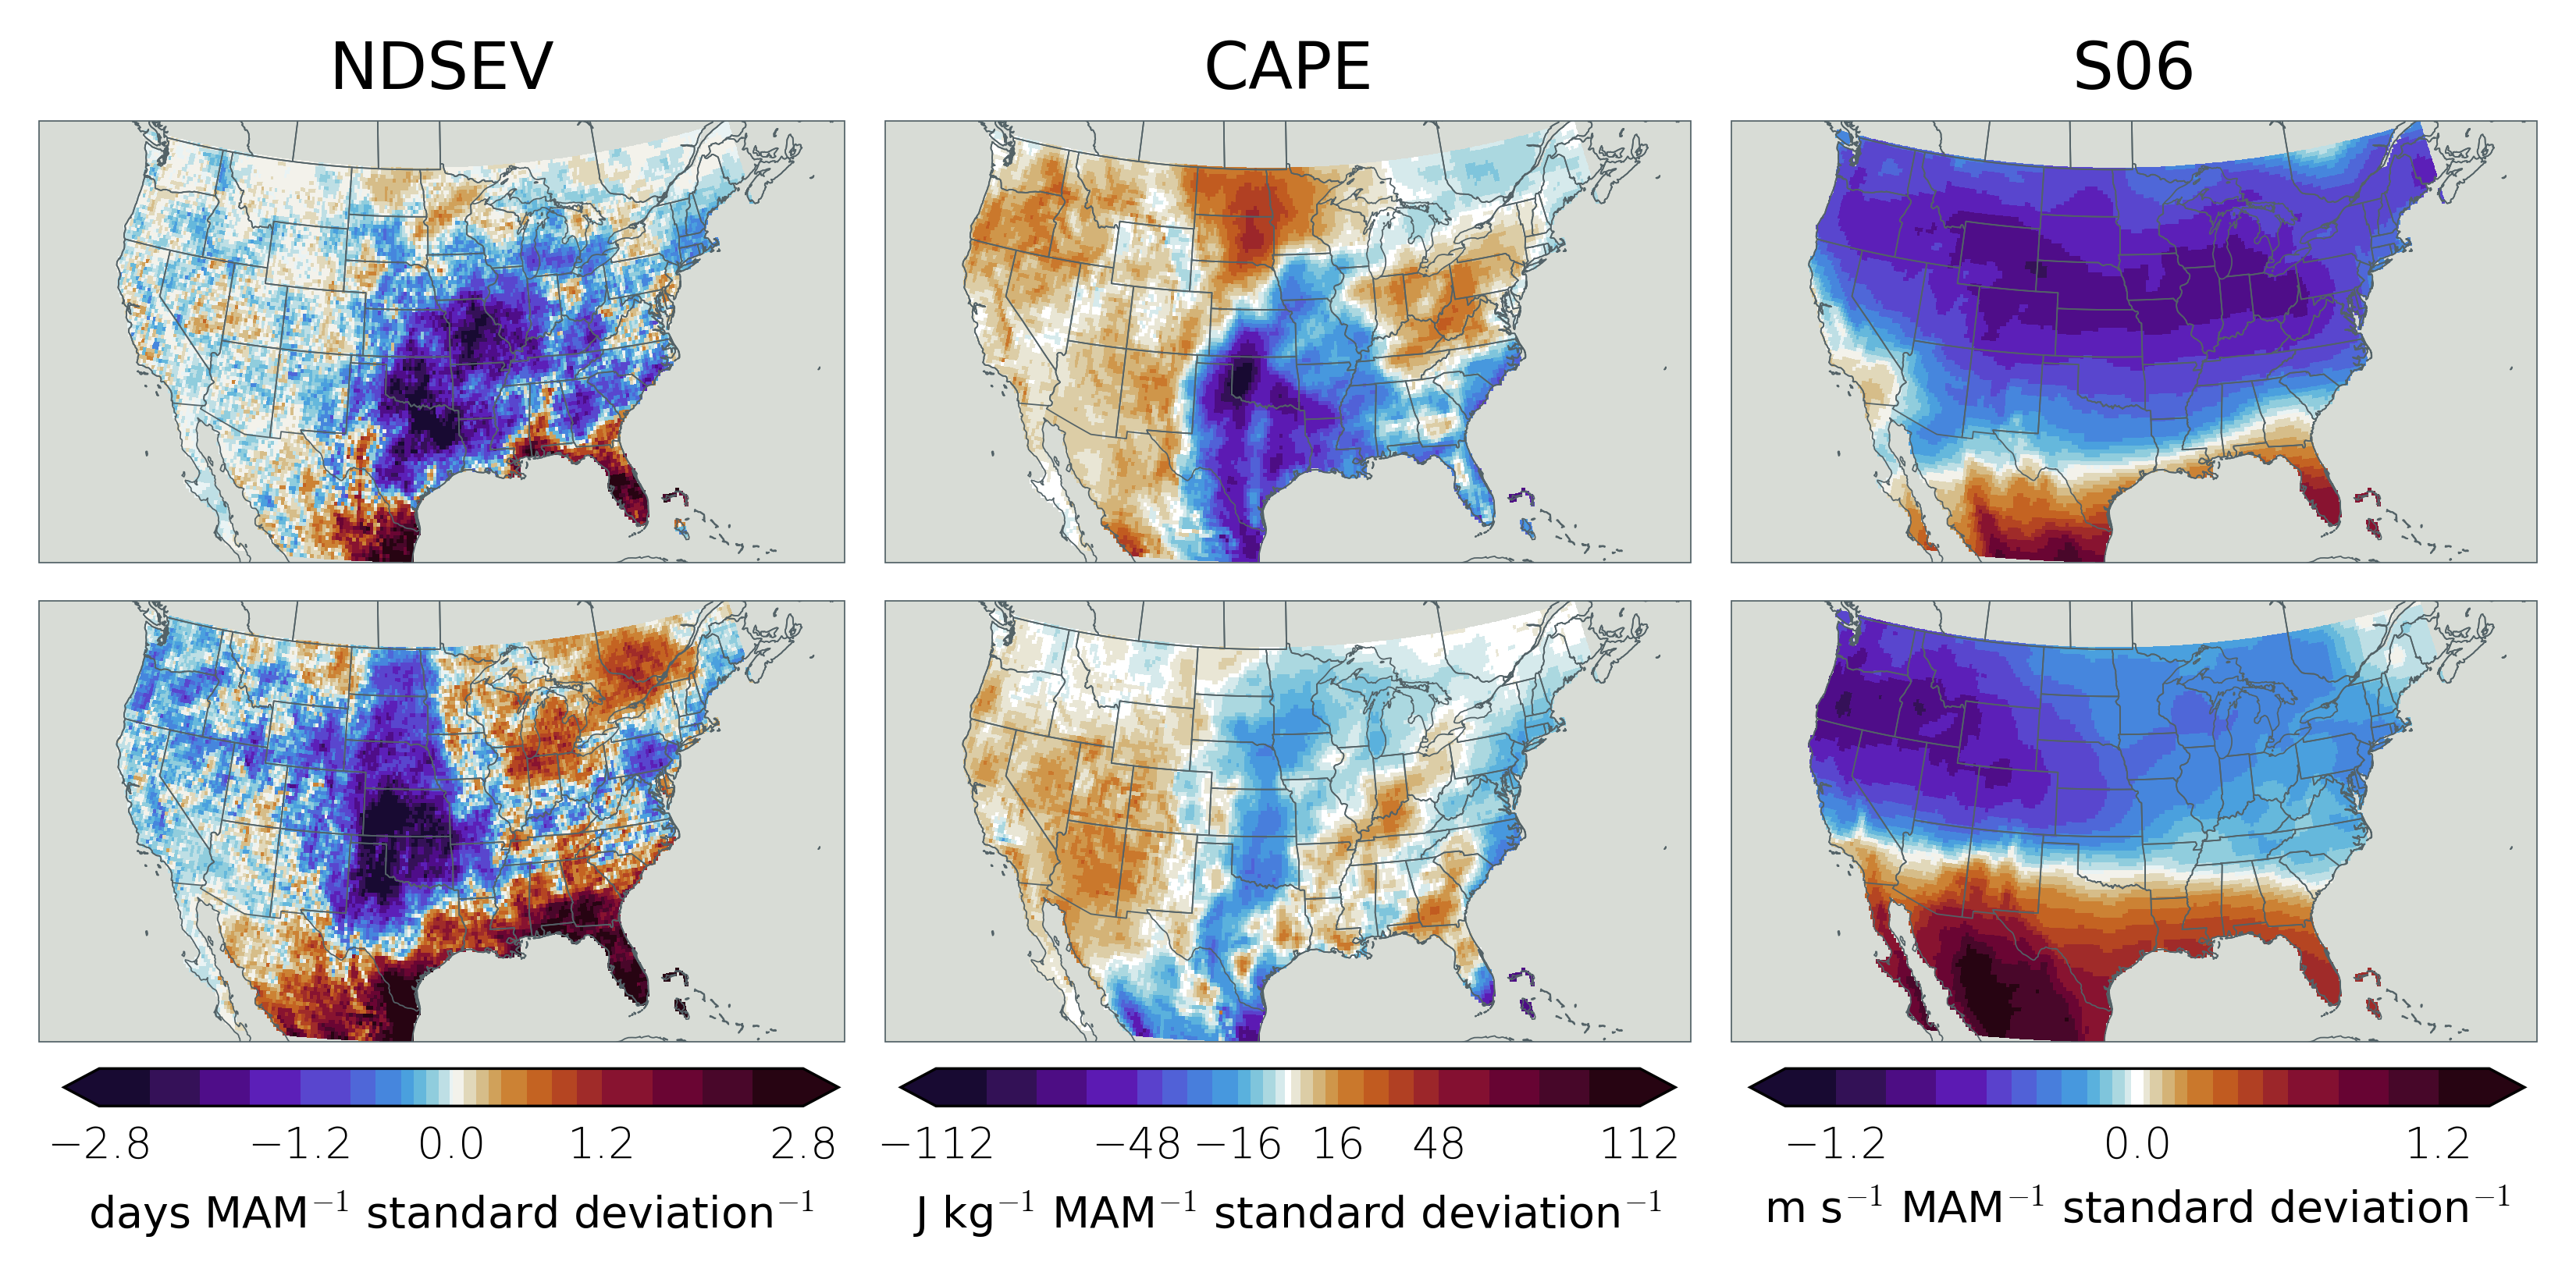

In [100]:
fig, ax = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2]]

s06_bounds = [-1.4, -1.2, -1, -0.8, -0.6, -0.5, -0.4, -0.3, -0.2, -0.15, -0.1, -0.05, -0.025, 0.025, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 1.2, 1.4]
cape_bounds = [-112, -96, -80, -64, -48, -40, -32, -24, -16, -12, -8, -4, -1, 1, 4, 8, 12, 16, 24, 32, 40, 48, 64, 80, 96, 112]
ndsev_bounds = [-2.8, -2.4, -2, -1.6, -1.2, -0.8, -0.6, -0.4, -0.3, -0.2, -0.1, -0.01, 0.01, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 1.2, 1.6, 2, 2.4, 2.8]

ndsev_norm = c.BoundaryNorm(ndsev_bounds, plt.get_cmap('cmr.fusion_r').N)
cape_norm = c.BoundaryNorm(cape_bounds, plt.get_cmap('cmr.fusion_r').N)
s06_norm = c.BoundaryNorm(s06_bounds, plt.get_cmap('cmr.fusion_r').N)

for i in range(6):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].add_feature(ct.feature.STATES, edgecolor='xkcd:gunmetal', lw=0.25)
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0.25)
    ax[i].set_facecolor('xkcd:light gray')

ax[0].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], (ndsev_multi_1940_1989.swapaxes(0, 2).swapaxes(1, 2)[1])*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_norm)

ax[1].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], (cape_multi_1940_1989.swapaxes(0, 2).swapaxes(1, 2)[1])*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=cape_norm)

ax[2].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], (s06_multi_1940_1989.swapaxes(0, 2).swapaxes(1, 2)[1])*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_norm)

ax[3].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], (ndsev_multi_1990_2024.swapaxes(0, 2).swapaxes(1, 2)[1])*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_norm)

ax[4].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], (cape_multi_1990_2024.swapaxes(0, 2).swapaxes(1, 2)[1])*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=cape_norm)

ax[5].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], (s06_multi_1990_2024.swapaxes(0, 2).swapaxes(1, 2)[1])*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_norm)

cax = plt.axes([0.01, .22, 0.31, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=ndsev_norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-2.8, -1.2, 0, 1.2, 2.8])
cbar.set_label(r'days MAM$^{-1}$ standard deviation$^{-1}$', size=8, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.5)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

cax2 = plt.axes([0.345, .22, 0.31, 0.02])
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=cape_norm), cax=cax2, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-112, -48, -16, 16, 48, 112])
cbar2.set_label(r'J kg$^{-1}$ MAM$^{-1}$ standard deviation$^{-1}$', size=8, fontweight='normal', color='black')
cbar2.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar2.outline.set_linewidth(0.5)
cbar2.outline.set_color('black')
# cbar.outline.set_visible(False)

cax3 = plt.axes([0.685, .22, 0.31, 0.02])
cbar3 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=s06_norm), cax=cax3, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-2.8, -1.2, 0, 1.2, 2.8])
cbar3.set_label(r'm s$^{-1}$ MAM$^{-1}$ standard deviation$^{-1}$', size=8, fontweight='normal', color='black')
cbar3.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar3.outline.set_linewidth(0.5)
cbar3.outline.set_color('black')
# cbar.outline.set_visible(False)

ax[0].set_title('NDSEV')
ax[1].set_title('CAPE')
ax[2].set_title('S06')

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.75, 
                    wspace=0.05, 
                    hspace=0.05)

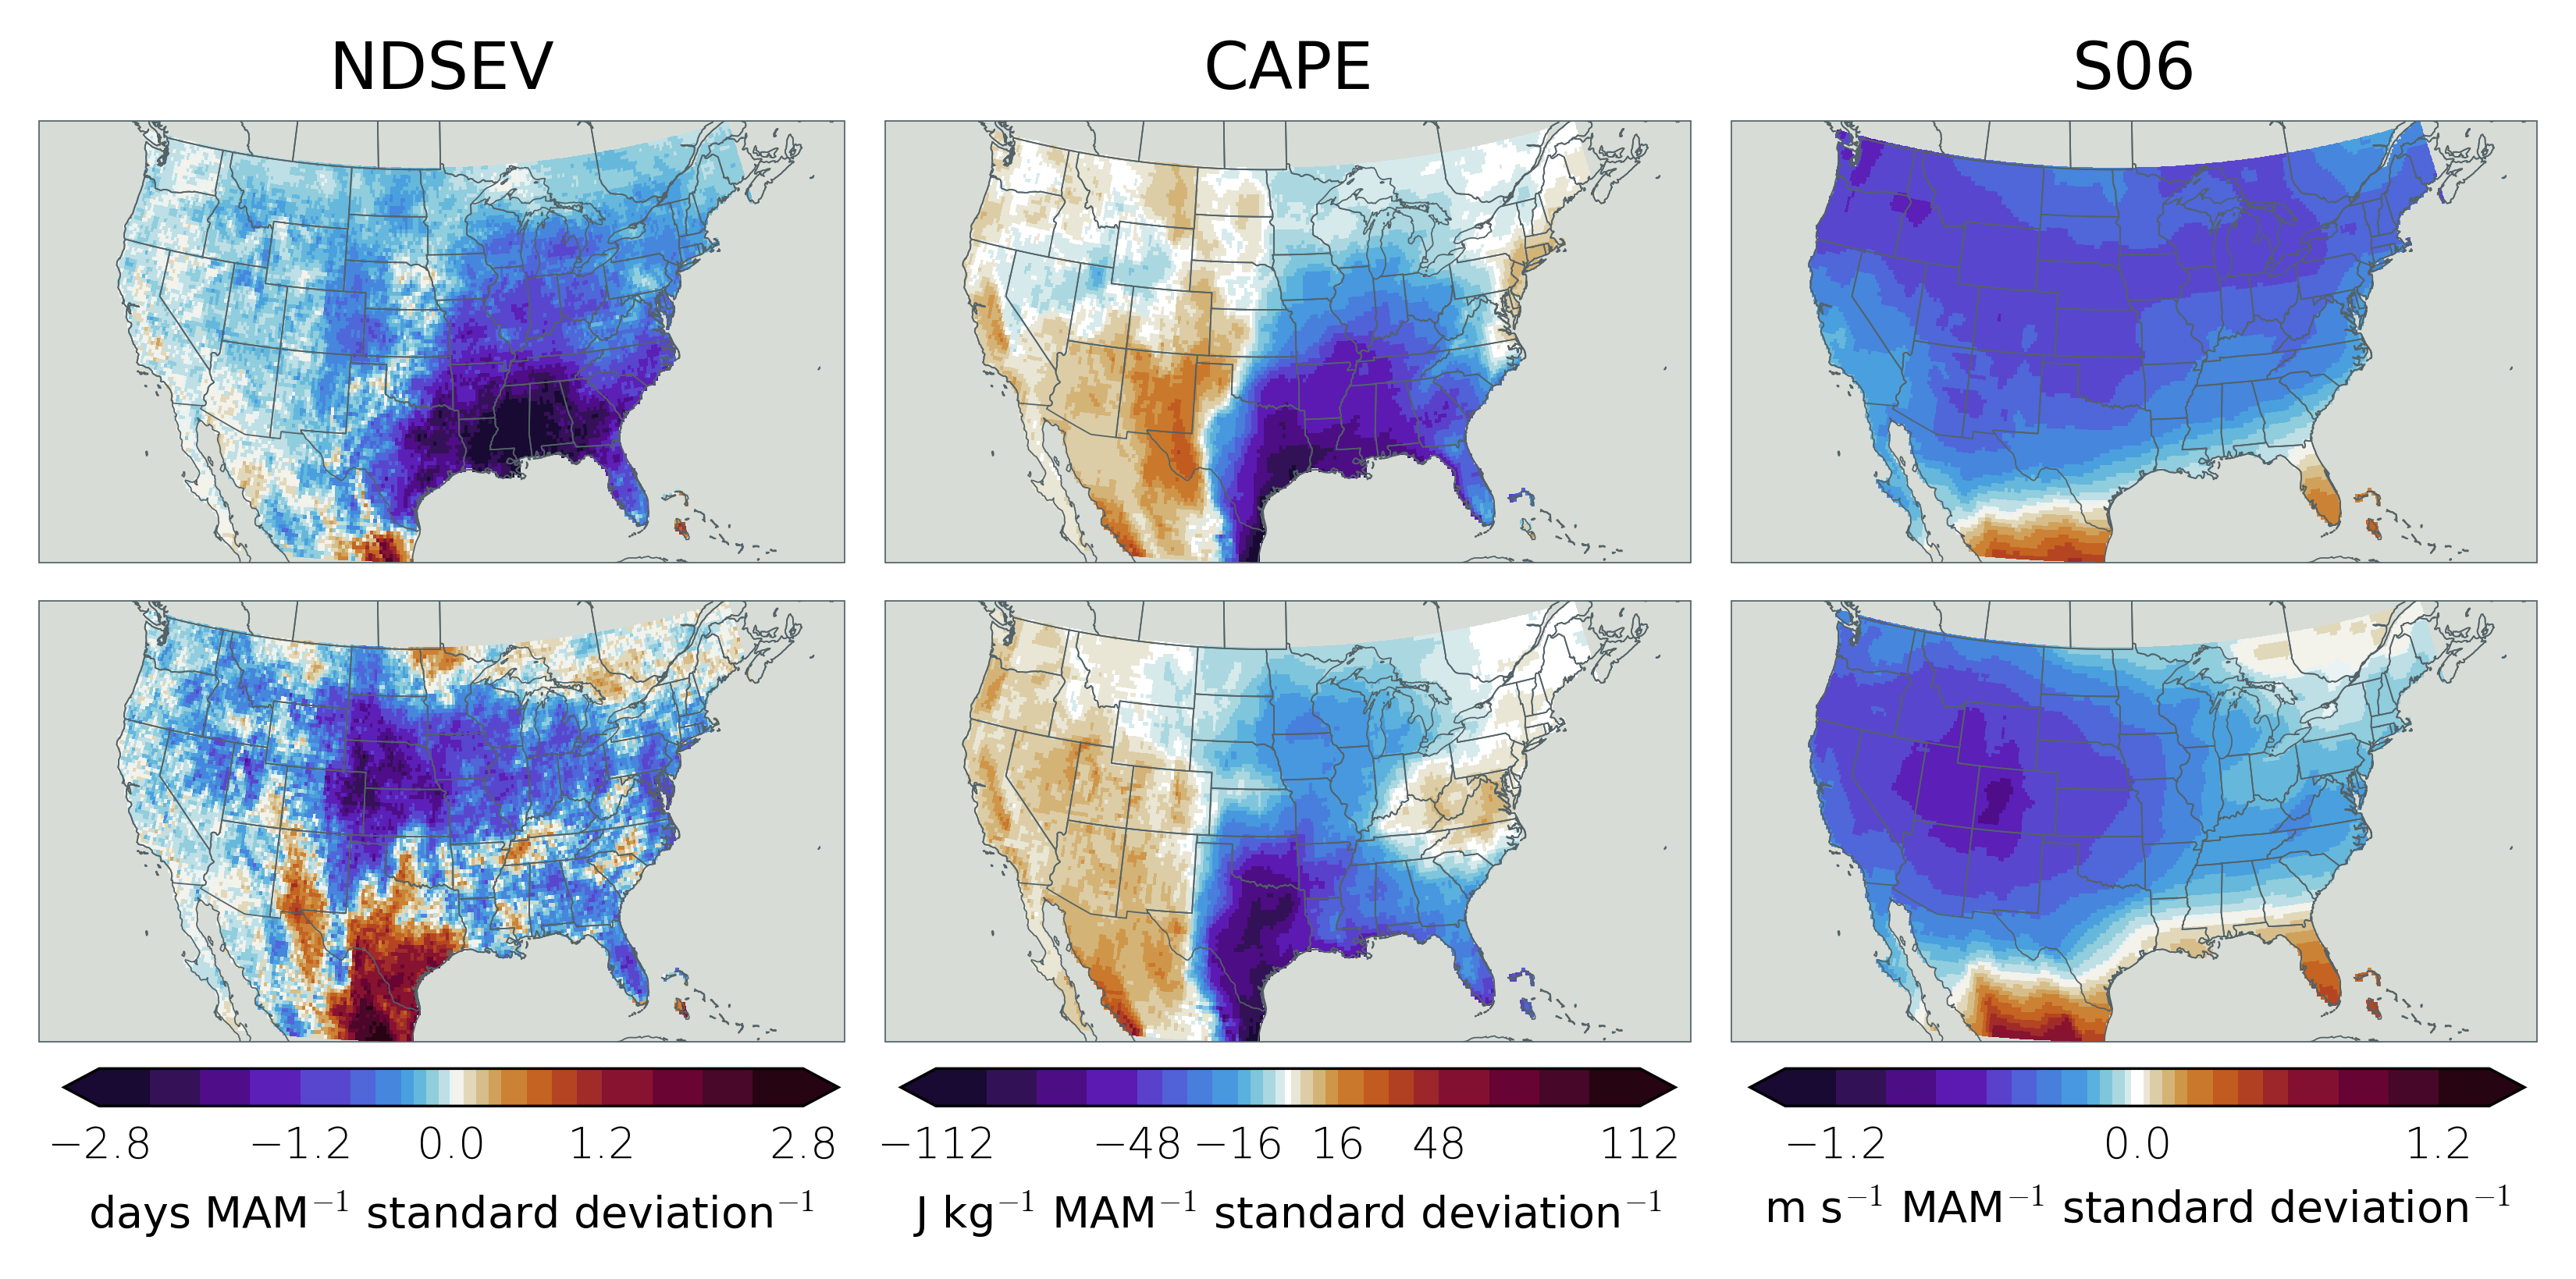

In [101]:
fig, ax = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2]]

s06_bounds = [-1.4, -1.2, -1, -0.8, -0.6, -0.5, -0.4, -0.3, -0.2, -0.15, -0.1, -0.05, -0.025, 0.025, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 1.2, 1.4]
cape_bounds = [-112, -96, -80, -64, -48, -40, -32, -24, -16, -12, -8, -4, -1, 1, 4, 8, 12, 16, 24, 32, 40, 48, 64, 80, 96, 112]
ndsev_bounds = [-2.8, -2.4, -2, -1.6, -1.2, -0.8, -0.6, -0.4, -0.3, -0.2, -0.1, -0.01, 0.01, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 1.2, 1.6, 2, 2.4, 2.8]

ndsev_norm = c.BoundaryNorm(ndsev_bounds, plt.get_cmap('cmr.fusion_r').N)
cape_norm = c.BoundaryNorm(cape_bounds, plt.get_cmap('cmr.fusion_r').N)
s06_norm = c.BoundaryNorm(s06_bounds, plt.get_cmap('cmr.fusion_r').N)

for i in range(6):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].add_feature(ct.feature.STATES, edgecolor='xkcd:gunmetal', lw=0.25)
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0.25)
    ax[i].set_facecolor('xkcd:light gray')

ax[0].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], ndsev_pdo_coef_1940_1989*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_norm)

ax[1].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], cape_pdo_coef_1940_1989*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=cape_norm)

ax[2].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], s06_pdo_coef_1940_1989*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_norm)

ax[3].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], ndsev_pdo_coef_1990_2024*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_norm)

ax[4].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], cape_pdo_coef_1990_2024*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=cape_norm)

ax[5].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], s06_pdo_coef_1990_2024*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_norm)

cax = plt.axes([0.01, .22, 0.31, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=ndsev_norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-2.8, -1.2, 0, 1.2, 2.8])
cbar.set_label(r'days MAM$^{-1}$ standard deviation$^{-1}$', size=8, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.5)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

cax2 = plt.axes([0.345, .22, 0.31, 0.02])
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=cape_norm), cax=cax2, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-112, -48, -16, 16, 48, 112])
cbar2.set_label(r'J kg$^{-1}$ MAM$^{-1}$ standard deviation$^{-1}$', size=8, fontweight='normal', color='black')
cbar2.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar2.outline.set_linewidth(0.5)
cbar2.outline.set_color('black')
# cbar.outline.set_visible(False)

cax3 = plt.axes([0.685, .22, 0.31, 0.02])
cbar3 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=s06_norm), cax=cax3, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-2.8, -1.2, 0, 1.2, 2.8])
cbar3.set_label(r'm s$^{-1}$ MAM$^{-1}$ standard deviation$^{-1}$', size=8, fontweight='normal', color='black')
cbar3.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar3.outline.set_linewidth(0.5)
cbar3.outline.set_color('black')
# cbar.outline.set_visible(False)

ax[0].set_title('NDSEV')
ax[1].set_title('CAPE')
ax[2].set_title('S06')

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.75, 
                    wspace=0.05, 
                    hspace=0.05)

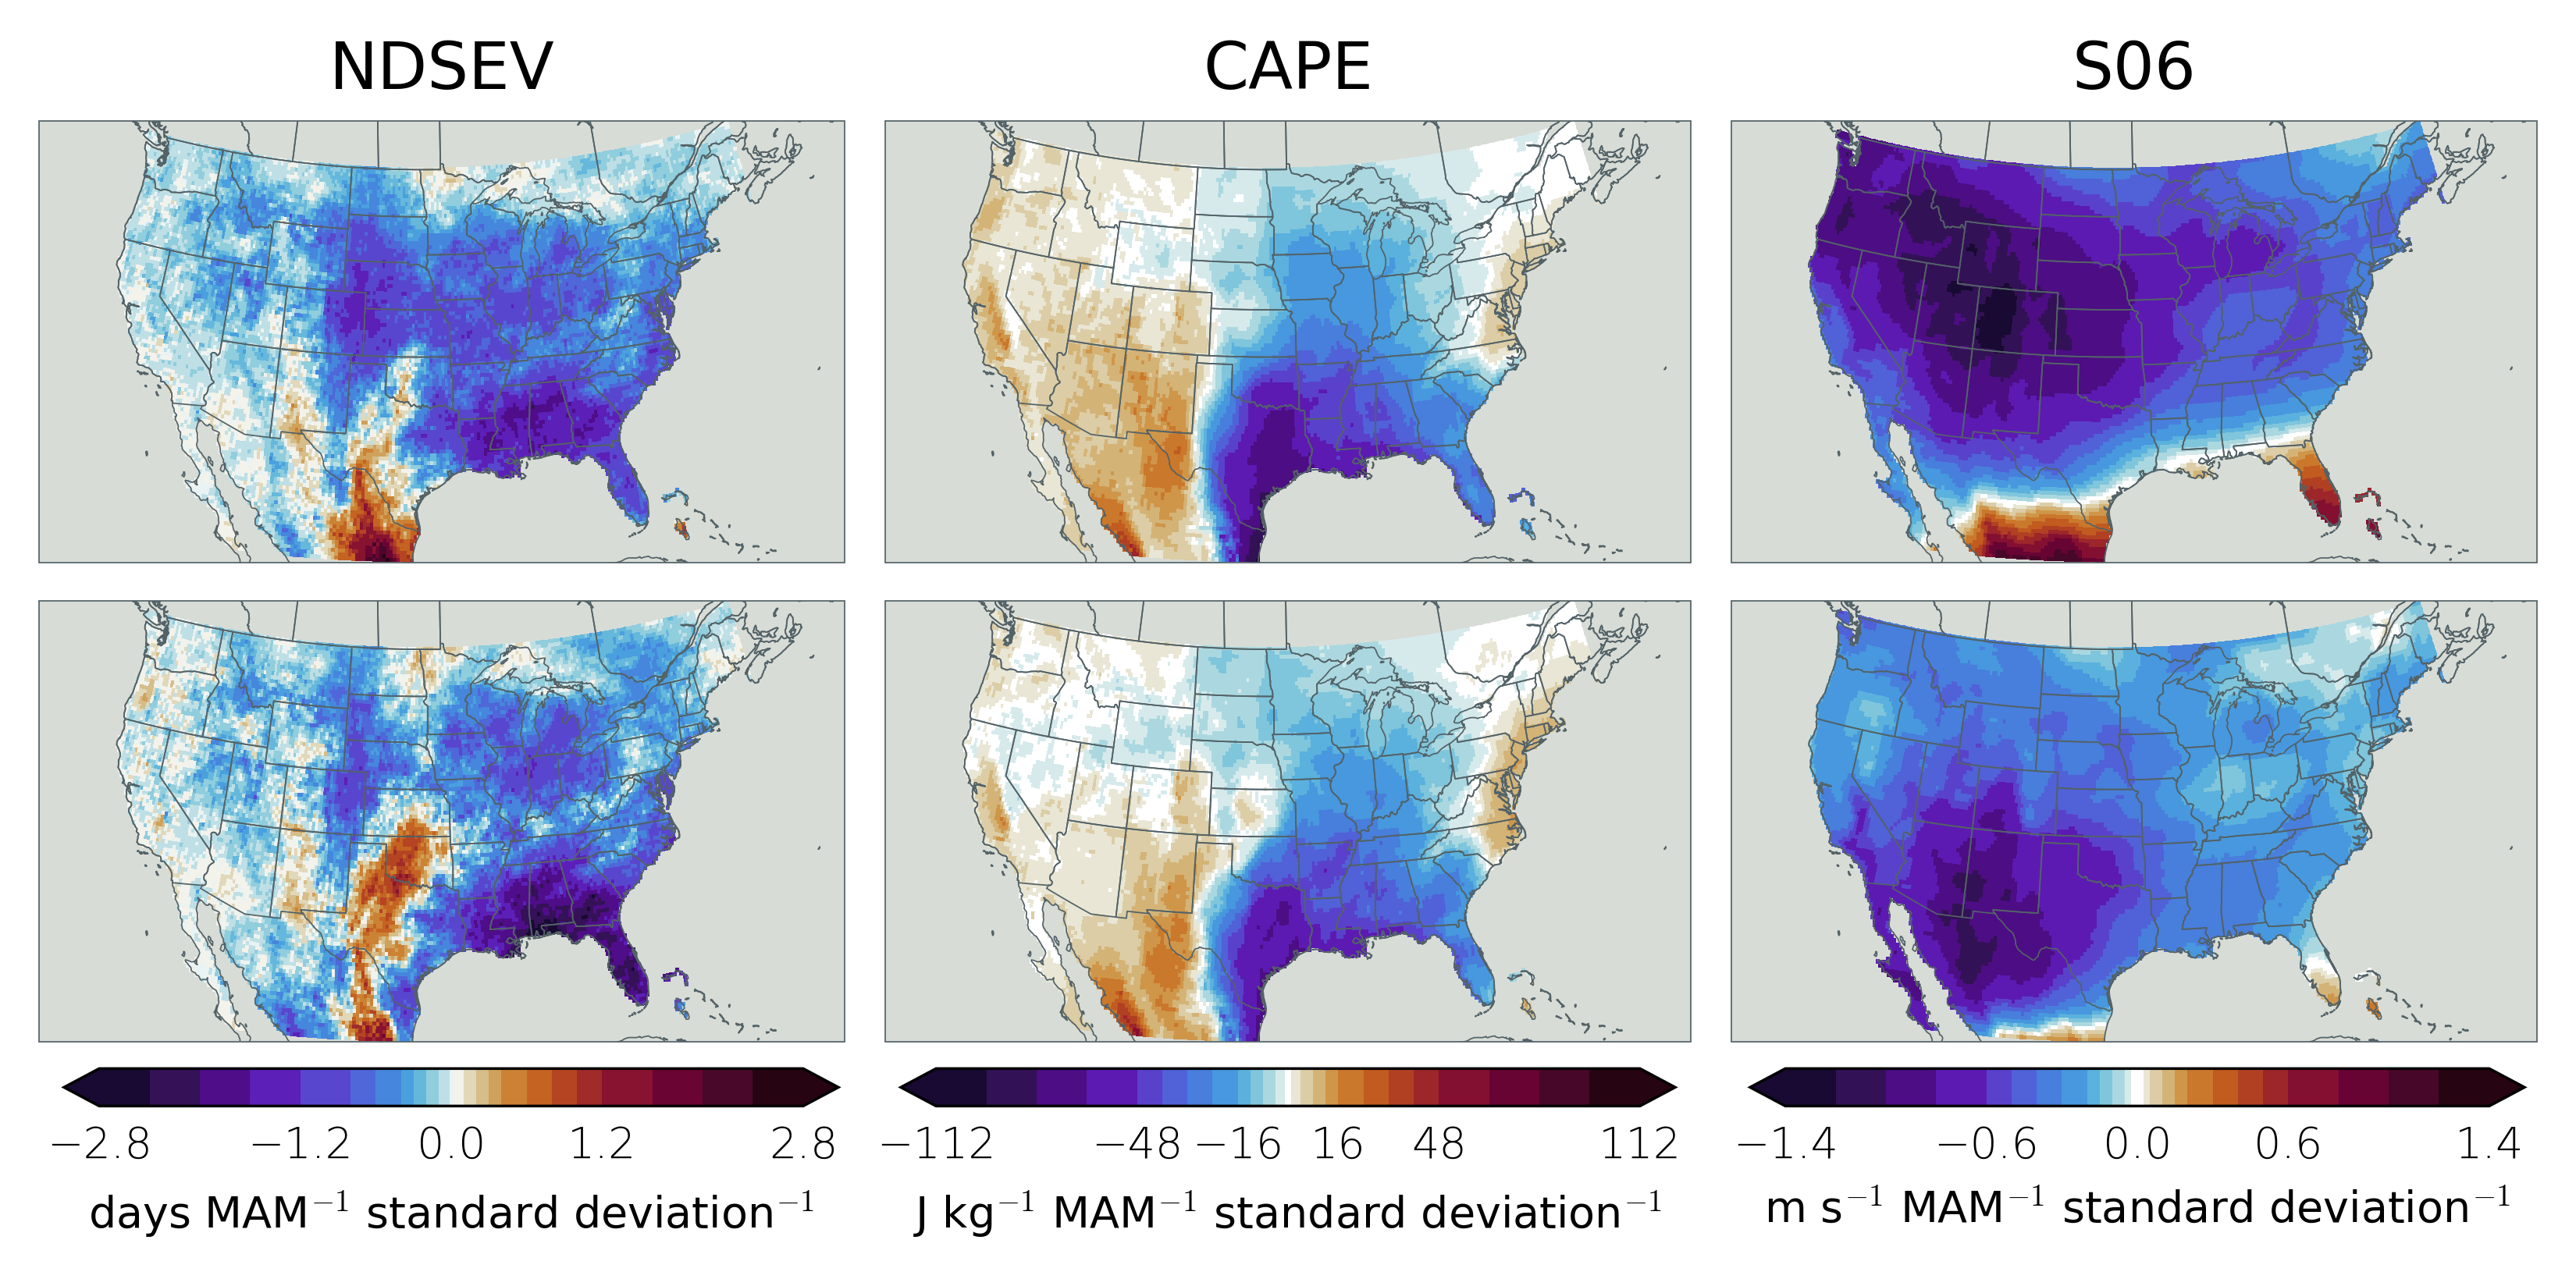

In [31]:
fig, ax = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2]]

s06_bounds = [-1.4, -1.2, -1, -0.8, -0.6, -0.5, -0.4, -0.3, -0.2, -0.15, -0.1, -0.05, -0.025, 0.025, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 1.2, 1.4]
cape_bounds = [-112, -96, -80, -64, -48, -40, -32, -24, -16, -12, -8, -4, -1, 1, 4, 8, 12, 16, 24, 32, 40, 48, 64, 80, 96, 112]
ndsev_bounds = [-2.8, -2.4, -2, -1.6, -1.2, -0.8, -0.6, -0.4, -0.3, -0.2, -0.1, -0.01, 0.01, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 1.2, 1.6, 2, 2.4, 2.8]

ndsev_norm = c.BoundaryNorm(ndsev_bounds, plt.get_cmap('cmr.fusion_r').N)
cape_norm = c.BoundaryNorm(cape_bounds, plt.get_cmap('cmr.fusion_r').N)
s06_norm = c.BoundaryNorm(s06_bounds, plt.get_cmap('cmr.fusion_r').N)

for i in range(6):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].add_feature(ct.feature.STATES, edgecolor='xkcd:gunmetal', lw=0.25)
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0.25)
    ax[i].set_facecolor('xkcd:light gray')

ax[0].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], ndsev_pdo_coef*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_norm)

ax[1].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], cape_pdo_coef*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=cape_norm)

ax[2].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], s06_pdo_coef*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=s06_norm)

ax[3].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], (ndsev_multi.swapaxes(0, 2).swapaxes(1, 2)[0])*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_norm)

ax[4].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], (cape_multi.swapaxes(0, 2).swapaxes(1, 2)[0])*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=cape_norm)

ax[5].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], (s06_multi.swapaxes(0, 2).swapaxes(1, 2)[0])*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=s06_norm)


cax = plt.axes([0.01, .22, 0.31, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=ndsev_norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-2.8, -1.2, 0, 1.2, 2.8])
cbar.set_label(r'days MAM$^{-1}$ standard deviation$^{-1}$', size=8, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.5)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

cax2 = plt.axes([0.345, .22, 0.31, 0.02])
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=cape_norm), cax=cax2, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-112, -48, -16, 16, 48, 112])
cbar2.set_label(r'J kg$^{-1}$ MAM$^{-1}$ standard deviation$^{-1}$', size=8, fontweight='normal', color='black')
cbar2.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar2.outline.set_linewidth(0.5)
cbar2.outline.set_color('black')
# cbar.outline.set_visible(False)

cax3 = plt.axes([0.685, .22, 0.31, 0.02])
cbar3 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=s06_norm), cax=cax3, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-1.4, -0.6, 0, 0.6, 1.4])
cbar3.set_label(r'm s$^{-1}$ MAM$^{-1}$ standard deviation$^{-1}$', size=8, fontweight='normal', color='black')
cbar3.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar3.outline.set_linewidth(0.5)
cbar3.outline.set_color('black')
# cbar.outline.set_visible(False)

ax[0].set_title('NDSEV')
ax[1].set_title('CAPE')
ax[2].set_title('S06')

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.75, 
                    wspace=0.05, 
                    hspace=0.05)

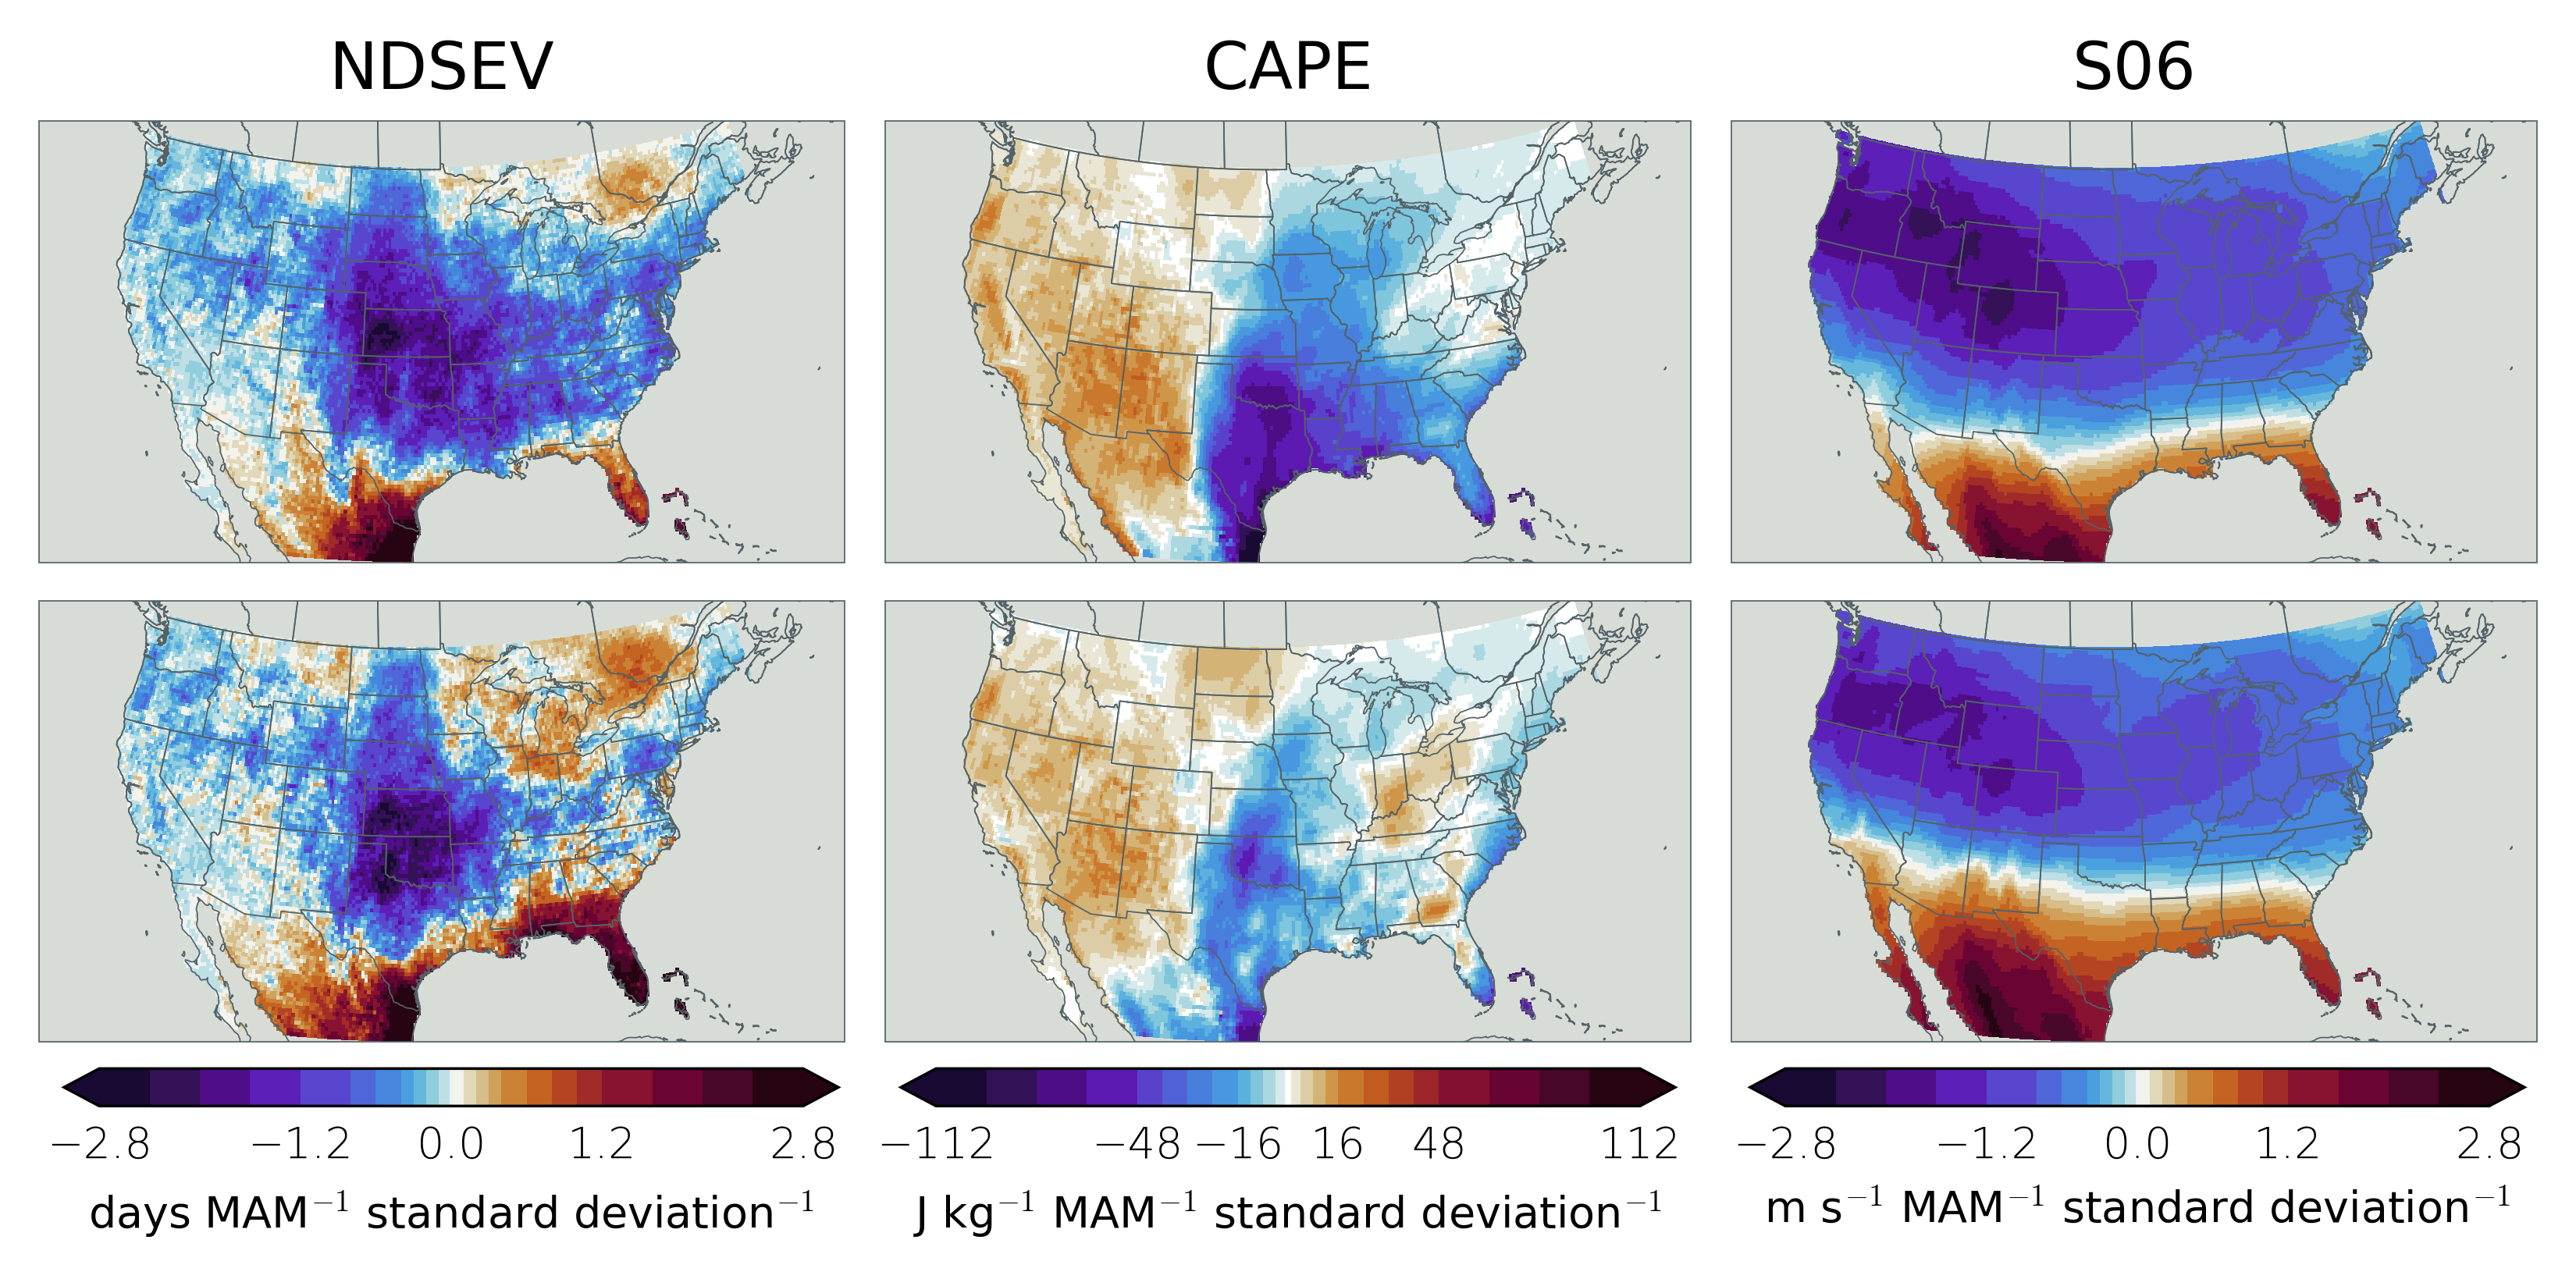

In [32]:
fig, ax = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

s06_bounds = [-2.8, -2.4, -2, -1.6, -1.2, -0.8, -0.6, -0.4, -0.3, -0.2, -0.1, -0.01, 0.01, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 1.2, 1.6, 2, 2.4, 2.8]
cape_bounds = [-112, -96, -80, -64, -48, -40, -32, -24, -16, -12, -8, -4, -1, 1, 4, 8, 12, 16, 24, 32, 40, 48, 64, 80, 96, 112]
ndsev_bounds = [-2.8, -2.4, -2, -1.6, -1.2, -0.8, -0.6, -0.4, -0.3, -0.2, -0.1, -0.01, 0.01, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 1.2, 1.6, 2, 2.4, 2.8]

ndsev_norm = c.BoundaryNorm(ndsev_bounds, plt.get_cmap('cmr.fusion_r').N)
cape_norm = c.BoundaryNorm(cape_bounds, plt.get_cmap('cmr.fusion_r').N)
s06_norm = c.BoundaryNorm(s06_bounds, plt.get_cmap('cmr.fusion_r').N)

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2]]

for i in range(6):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].add_feature(ct.feature.STATES, edgecolor='xkcd:gunmetal', lw=0.25)
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0.25)
    ax[i].set_facecolor('xkcd:light gray')

ax[0].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], ndsev_nino_coef*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_norm)

ax[1].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], cape_nino_coef*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=cape_norm)

ax[2].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], s06_nino_coef*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=s06_norm)

ax[3].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], (ndsev_multi.swapaxes(0, 2).swapaxes(1, 2)[1])*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_norm)

ax[4].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], (cape_multi.swapaxes(0, 2).swapaxes(1, 2)[1])*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=cape_norm)

ax[5].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], (s06_multi.swapaxes(0, 2).swapaxes(1, 2)[1])*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=s06_norm)

cax = plt.axes([0.01, .22, 0.31, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=ndsev_norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-2.8, -1.2, 0, 1.2, 2.8])
cbar.set_label(r'days MAM$^{-1}$ standard deviation$^{-1}$', size=8, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.5)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

cax2 = plt.axes([0.345, .22, 0.31, 0.02])
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=cape_norm), cax=cax2, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-112, -48, -16, 16, 48, 112])
cbar2.set_label(r'J kg$^{-1}$ MAM$^{-1}$ standard deviation$^{-1}$', size=8, fontweight='normal', color='black')
cbar2.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar2.outline.set_linewidth(0.5)
cbar2.outline.set_color('black')
# cbar.outline.set_visible(False)

cax3 = plt.axes([0.685, .22, 0.31, 0.02])
cbar3 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=s06_norm), cax=cax3, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-2.8, -1.2, 0, 1.2, 2.8])
cbar3.set_label(r'm s$^{-1}$ MAM$^{-1}$ standard deviation$^{-1}$', size=8, fontweight='normal', color='black')
cbar3.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar3.outline.set_linewidth(0.5)
cbar3.outline.set_color('black')
# cbar.outline.set_visible(False)

ax[0].set_title('NDSEV')
ax[1].set_title('CAPE')
ax[2].set_title('S06')

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.75, 
                    wspace=0.05, 
                    hspace=0.05)

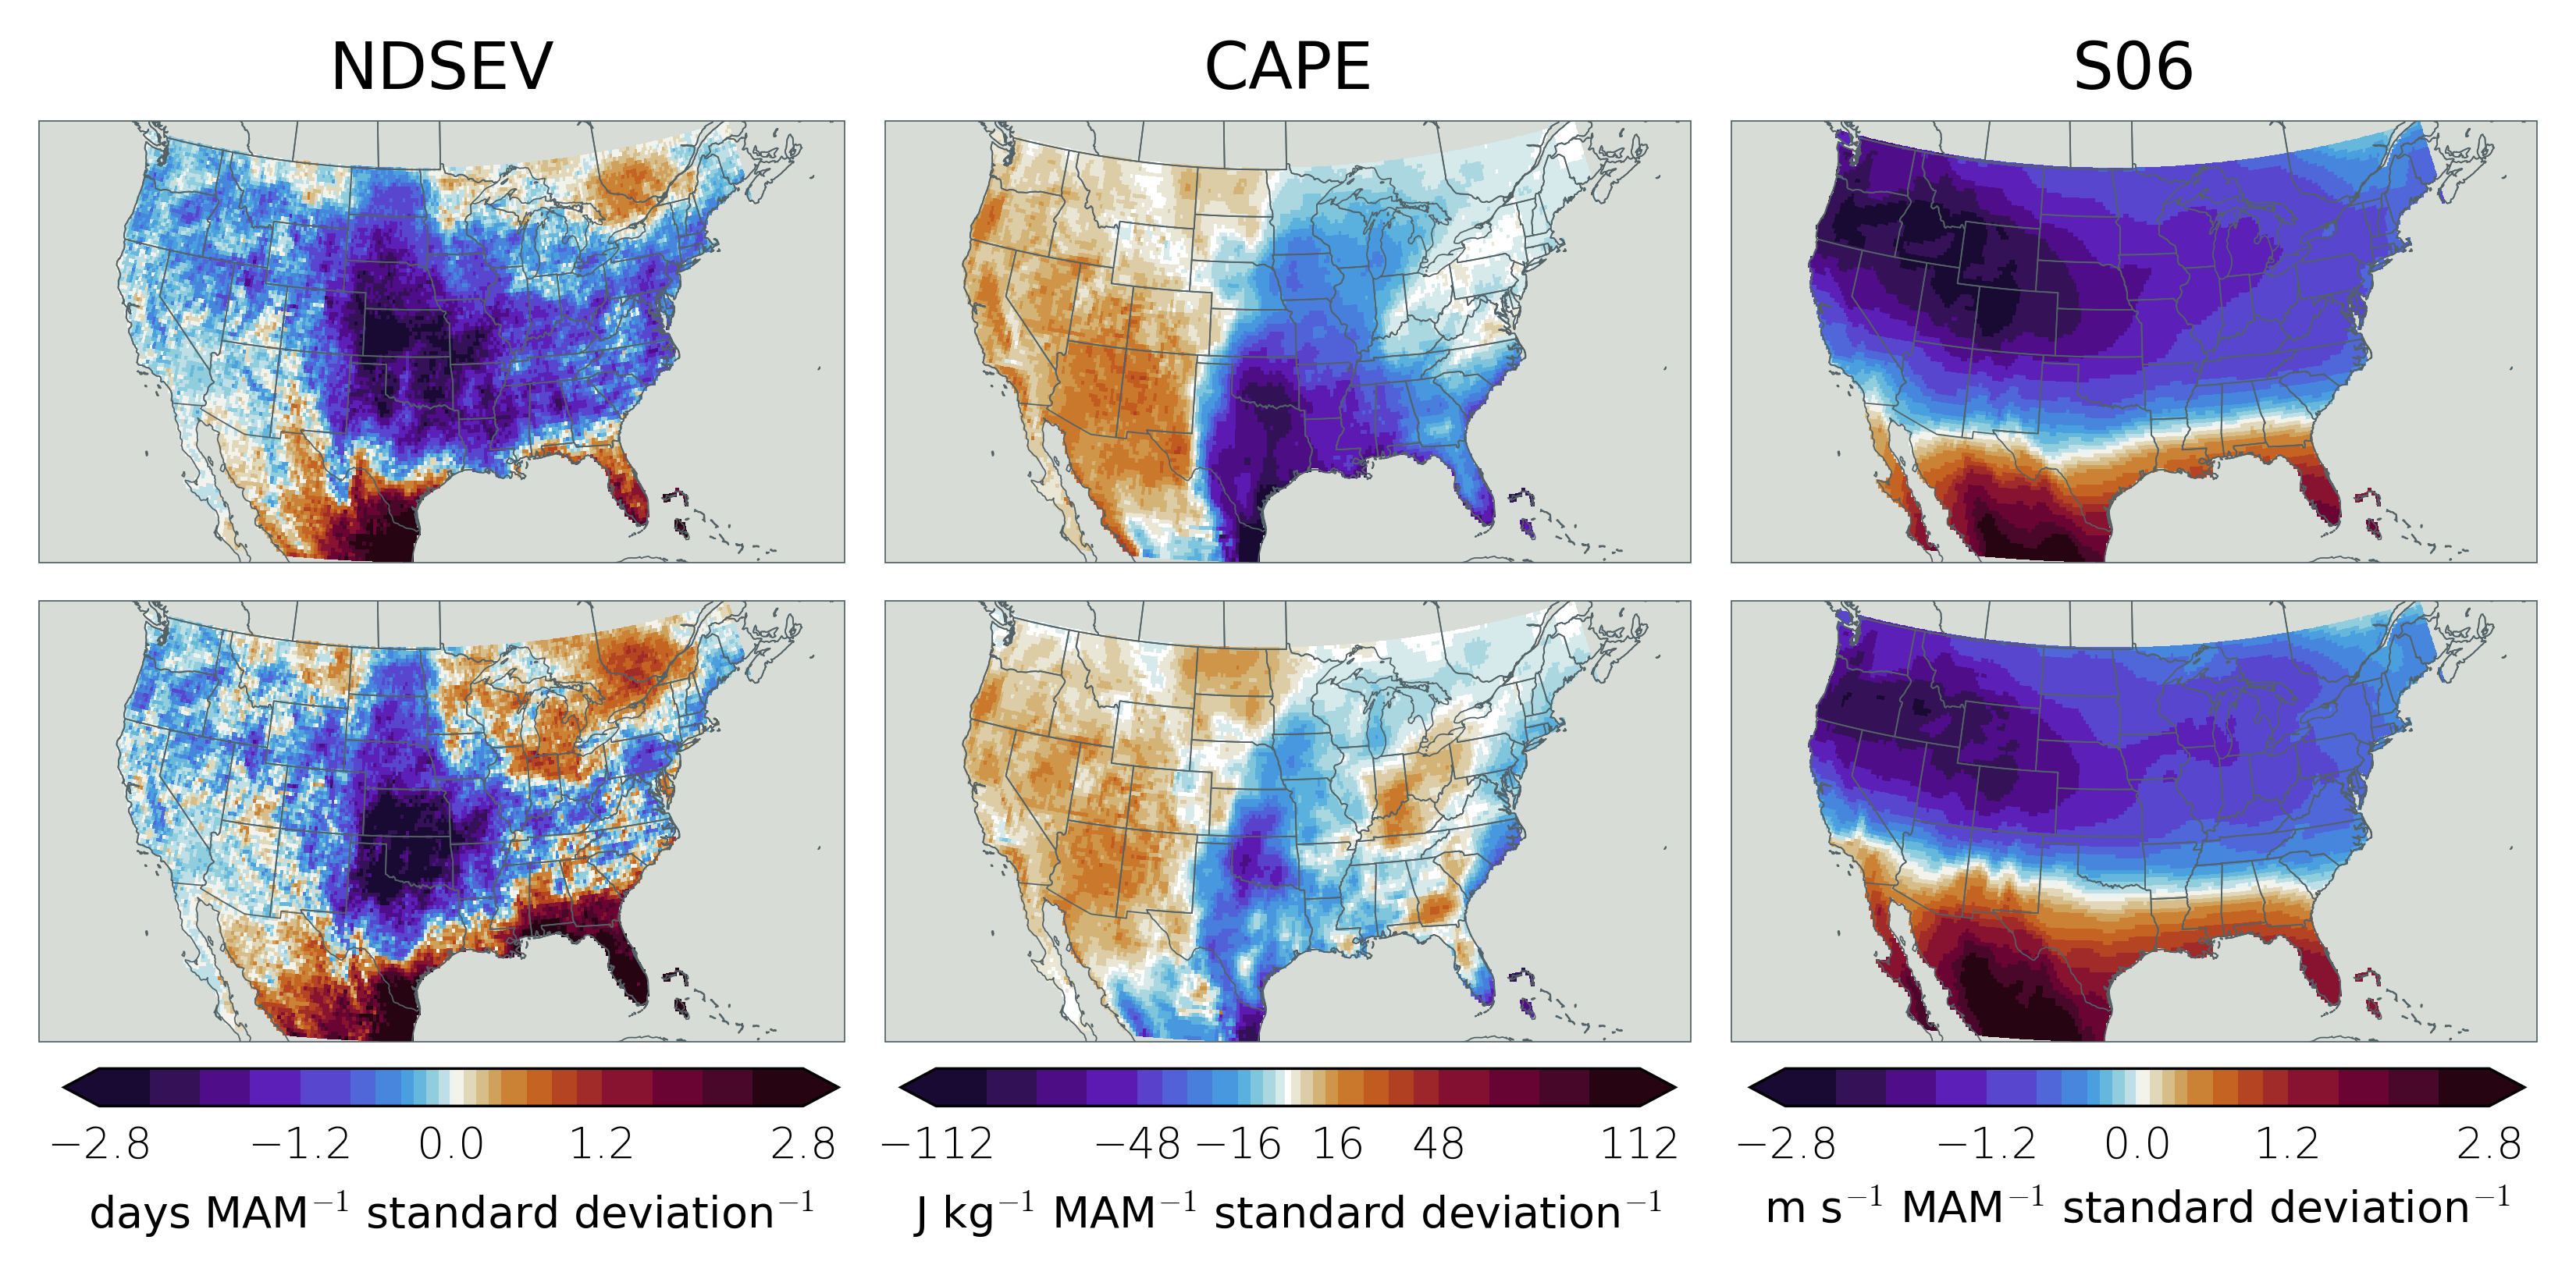

In [47]:
fig, ax = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2]]

s06_bounds = [-1.4, -1.2, -1, -0.8, -0.6, -0.5, -0.4, -0.3, -0.2, -0.15, -0.1, -0.05, -0.025, 0.025, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 1.2, 1.4]
cape_bounds = [-112, -96, -80, -64, -48, -40, -32, -24, -16, -12, -8, -4, -1, 1, 4, 8, 12, 16, 24, 32, 40, 48, 64, 80, 96, 112]
ndsev_bounds = [-2.8, -2.4, -2, -1.6, -1.2, -0.8, -0.6, -0.4, -0.3, -0.2, -0.1, -0.01, 0.01, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 1.2, 1.6, 2, 2.4, 2.8]

ndsev_norm = c.BoundaryNorm(ndsev_bounds, plt.get_cmap('cmr.fusion_r').N)
cape_norm = c.BoundaryNorm(cape_bounds, plt.get_cmap('cmr.fusion_r').N)
s06_norm = c.BoundaryNorm(s06_bounds, plt.get_cmap('cmr.fusion_r').N)

for i in range(6):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].add_feature(ct.feature.STATES, edgecolor='xkcd:gunmetal', lw=0.25)
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0.25)
    ax[i].set_facecolor('xkcd:light gray')

ax[0].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], ndsev_nino_rolling_coef*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_norm)

ax[1].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], cape_nino_rolling_coef*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=cape_norm)

ax[2].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], s06_nino_rolling_coef*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_norm)

ax[3].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], (ndsev_multi_rolling.swapaxes(0, 2).swapaxes(1, 2)[1])*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_norm)

ax[4].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], (cape_multi_rolling.swapaxes(0, 2).swapaxes(1, 2)[1])*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=cape_norm)

ax[5].pcolormesh(diff_ndsev['longitude'], diff_ndsev['latitude'], (s06_multi_rolling.swapaxes(0, 2).swapaxes(1, 2)[1])*era5_land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_norm)


cax = plt.axes([0.01, .22, 0.31, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=ndsev_norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-2.8, -1.2, 0, 1.2, 2.8])
cbar.set_label(r'days MAM$^{-1}$ standard deviation$^{-1}$', size=8, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.5)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

cax2 = plt.axes([0.345, .22, 0.31, 0.02])
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=cape_norm), cax=cax2, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-112, -48, -16, 16, 48, 112])
cbar2.set_label(r'J kg$^{-1}$ MAM$^{-1}$ standard deviation$^{-1}$', size=8, fontweight='normal', color='black')
cbar2.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar2.outline.set_linewidth(0.5)
cbar2.outline.set_color('black')
# cbar.outline.set_visible(False)

cax3 = plt.axes([0.685, .22, 0.31, 0.02])
cbar3 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=ndsev_norm), cax=cax3, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-2.8, -1.2, 0, 1.2, 2.8])
cbar3.set_label(r'm s$^{-1}$ MAM$^{-1}$ standard deviation$^{-1}$', size=8, fontweight='normal', color='black')
cbar3.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar3.outline.set_linewidth(0.5)
cbar3.outline.set_color('black')
# cbar.outline.set_visible(False)

ax[0].set_title('NDSEV')
ax[1].set_title('CAPE')
ax[2].set_title('S06')

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.75, 
                    wspace=0.05, 
                    hspace=0.05)